# MCResNet Training Pipeline Test

**Purpose:** Test the complete training pipeline locally before running on Colab

**Test Scope:**
- Synthetic RGB-D data (simulates NYU Depth V2 format)
- Small dataset (100 train, 20 val samples)
- 1-2 epochs training
- All optimizations enabled
- Verify gradient clipping, AMP, etc.

**Expected Time:** 2-3 minutes on CPU, <1 minute on GPU

## 1. Setup & Imports

In [1]:
import sys
import os
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")
print(f"Current directory: {Path.cwd()}")

Project root: /Users/gclinger/Documents/projects/Multi-Stream-Neural-Networks
Current directory: /Users/gclinger/Documents/projects/Multi-Stream-Neural-Networks/notebooks


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import random
from typing import Tuple

# Import MCResNet
from src.models.multi_channel.mc_resnet import mc_resnet18, mc_resnet50

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    print(f"MPS (Apple Silicon) available")
print("✅ Imports successful!")

PyTorch version: 2.7.1
CUDA available: False
MPS (Apple Silicon) available
✅ Imports successful!


## 2. Create Dataset (Choose: Synthetic OR Real NYU Depth V2)

**Option A: Synthetic Data** - Fast testing (no download needed)
**Option B: Real NYU Depth V2** - Realistic testing (requires dataset download)

We'll create synthetic RGB-D dataset by default for quick testing.
If you have NYU Depth V2 downloaded, uncomment Option B below.

In [3]:
class SyntheticRGBDDataset(Dataset):
    """
    Synthetic RGB-D dataset for testing MCResNet training pipeline.
    Simulates NYU Depth V2 format.
    """
    
    def __init__(self, num_samples: int, num_classes: int = 13, image_size: int = 224, 
                 transform=None, train: bool = True):
        self.num_samples = num_samples
        self.num_classes = num_classes
        self.image_size = image_size
        self.transform = transform
        self.train = train
        
        # Generate synthetic data (done once at init)
        torch.manual_seed(42 if train else 43)
        
        # RGB images (simulated)
        self.rgb_images = torch.rand(num_samples, 3, image_size, image_size)
        
        # Depth maps (simulated - correlated with RGB for realism)
        # Use grayscale of RGB + noise as depth proxy
        depth_base = self.rgb_images.mean(dim=1, keepdim=True)  # [N, 1, H, W]
        depth_noise = torch.rand(num_samples, 1, image_size, image_size) * 0.3
        self.depth_maps = torch.clamp(depth_base + depth_noise, 0, 1)
        
        # Labels (random but consistent)
        self.labels = torch.randint(0, num_classes, (num_samples,))
        
        print(f"Created {'train' if train else 'val'} dataset:")
        print(f"  Samples: {num_samples}")
        print(f"  RGB shape: {self.rgb_images.shape}")
        print(f"  Depth shape: {self.depth_maps.shape}")
        print(f"  Labels shape: {self.labels.shape}")
        print(f"  Classes: {num_classes}")
    
    def __len__(self) -> int:
        return self.num_samples
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        rgb = self.rgb_images[idx]
        depth = self.depth_maps[idx]
        label = self.labels[idx]
        
        # Apply synchronized augmentation
        if self.transform:
            seed = random.randint(0, 2**32 - 1)
            
            # Apply to RGB
            torch.manual_seed(seed)
            random.seed(seed)
            rgb = self.transform(rgb)
            
            # Apply to depth with same seed
            torch.manual_seed(seed)
            random.seed(seed)
            depth = self.transform(depth)
        
        return rgb, depth, label

### Option A: Synthetic Dataset (Default - Fast Testing)

### Option B: Real NYU Depth V2 Dataset (Uncomment to Use)

To use real NYU Depth V2 data:

1. **Download the dataset:**
   ```bash
   # In terminal or separate notebook cell:
   wget http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat
   ```
   Or download manually from: http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat (~2.8 GB)

2. **Update the path** below to point to your downloaded file

3. **Uncomment the code** below and comment out Option A

In [ ]:
# OPTION B: Real NYU Depth V2 Dataset
# Uncomment the code below to use real data instead of synthetic

# from src.data_utils.nyu_depth_dataset import create_nyu_dataloaders
# 
# # Path to your downloaded NYU Depth V2 dataset
# NYU_DATASET_PATH = "/path/to/nyu_depth_v2_labeled.mat"  # UPDATE THIS PATH
# 
# print("Loading NYU Depth V2 dataset...")
# print(f"Dataset path: {NYU_DATASET_PATH}")
# 
# # Create dataloaders
# train_loader, val_loader = create_nyu_dataloaders(
#     h5_file_path=NYU_DATASET_PATH,
#     batch_size=16,  # Adjust based on your RAM
#     num_workers=2,  # Adjust based on your CPU cores
#     target_size=(224, 224),
#     num_classes=13  # Scene classification
# )
# 
# print(f"\n✅ NYU Depth V2 dataset loaded!")
# print(f"  Train batches: {len(train_loader)}")
# print(f"  Val batches: {len(val_loader)}")
# print(f"  Train samples: {len(train_loader.dataset)}")
# print(f"  Val samples: {len(val_loader.dataset)}")
# 
# # Test loading a batch
# rgb_batch, depth_batch, label_batch = next(iter(train_loader))
# print(f"\nSample batch shapes:")
# print(f"  RGB: {rgb_batch.shape}")
# print(f"  Depth: {depth_batch.shape}")
# print(f"  Labels: {label_batch.shape}")
# print("\n✅ Real NYU data ready for training!")

In [4]:
# Create transforms (simple for testing)
# Note: We DON'T normalize here because RGB (3ch) and Depth (1ch) need different normalization
# We'll normalize manually in __getitem__ if needed, or train without normalization for synthetic data
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5)
])

val_transform = None  # No augmentation for validation

# Create datasets
train_dataset = SyntheticRGBDDataset(
    num_samples=100,  # Small dataset for testing
    num_classes=13,
    transform=train_transform,
    train=True
)

val_dataset = SyntheticRGBDDataset(
    num_samples=20,
    num_classes=13,
    transform=val_transform,
    train=False
)

print("\n✅ Datasets created successfully!")

Created train dataset:
  Samples: 100
  RGB shape: torch.Size([100, 3, 224, 224])
  Depth shape: torch.Size([100, 1, 224, 224])
  Labels shape: torch.Size([100])
  Classes: 13
Created val dataset:
  Samples: 20
  RGB shape: torch.Size([20, 3, 224, 224])
  Depth shape: torch.Size([20, 1, 224, 224])
  Labels shape: torch.Size([20])
  Classes: 13

✅ Datasets created successfully!


## 3. Create DataLoaders

In [5]:
# Configuration
BATCH_SIZE = 16  # Small batch for CPU testing
NUM_WORKERS = 0  # Use 0 for debugging, 2-4 for actual training

# Detect device
if torch.cuda.is_available():
    device = 'cuda'
    pin_memory = True
    BATCH_SIZE = 32  # Can use larger batch on GPU
elif torch.backends.mps.is_available():
    device = 'mps'
    pin_memory = False
else:
    device = 'cpu'
    pin_memory = False

print(f"Using device: {device}")
print(f"Batch size: {BATCH_SIZE}")

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=pin_memory
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=pin_memory
)

print(f"\nTrain batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

# Test loading a batch
rgb_batch, depth_batch, label_batch = next(iter(train_loader))
print(f"\nSample batch shapes:")
print(f"  RGB: {rgb_batch.shape}")
print(f"  Depth: {depth_batch.shape}")
print(f"  Labels: {label_batch.shape}")
print("\n✅ DataLoaders created successfully!")

Using device: mps
Batch size: 16

Train batches: 7
Val batches: 2

Sample batch shapes:
  RGB: torch.Size([16, 3, 224, 224])
  Depth: torch.Size([16, 1, 224, 224])
  Labels: torch.Size([16])

✅ DataLoaders created successfully!


## 4. Visualize Sample Data

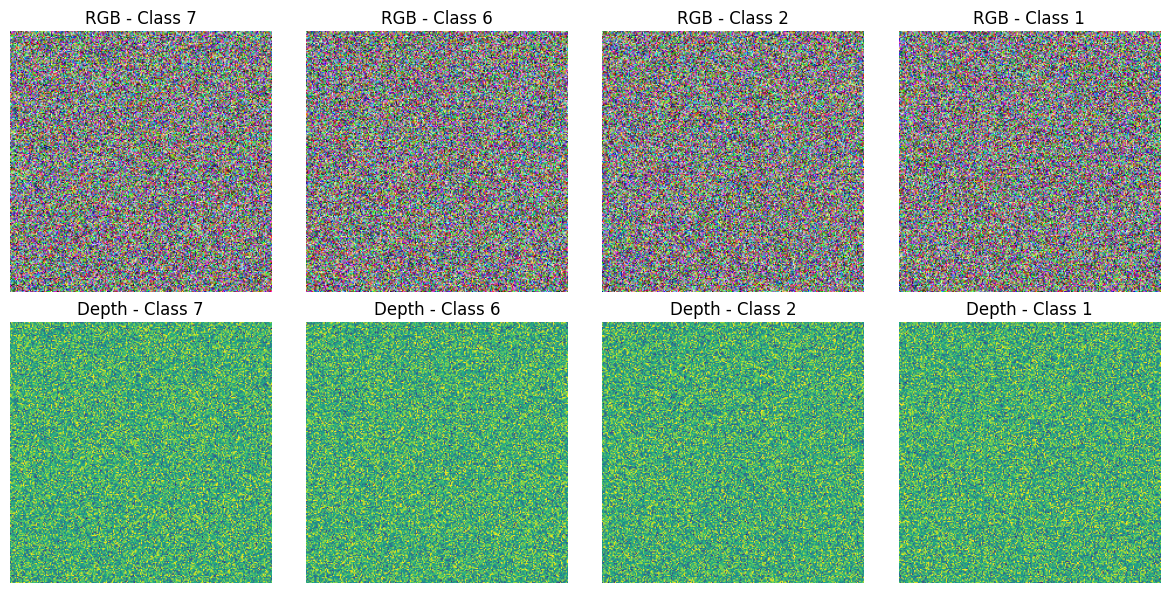

✅ Data visualization complete!


In [6]:
# Visualize a few samples
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for i in range(4):
    rgb_sample = rgb_batch[i].cpu()
    depth_sample = depth_batch[i].cpu()
    label = label_batch[i].item()
    
    # Data is already in [0, 1] range (no normalization applied)
    rgb_vis = torch.clamp(rgb_sample, 0, 1)
    depth_vis = torch.clamp(depth_sample, 0, 1)
    
    # Plot RGB
    axes[0, i].imshow(rgb_vis.permute(1, 2, 0))
    axes[0, i].set_title(f"RGB - Class {label}")
    axes[0, i].axis('off')
    
    # Plot Depth
    axes[1, i].imshow(depth_vis.squeeze(), cmap='viridis')
    axes[1, i].set_title(f"Depth - Class {label}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()
print("✅ Data visualization complete!")

## 5. Create & Compile MCResNet Model

In [7]:
# Model configuration
MODEL_CONFIG = {
    'architecture': 'resnet18',  # or 'resnet50'
    'num_classes': 13,
    'stream1_channels': 3,  # RGB
    'stream2_channels': 1,  # Depth
    'device': device,
    'use_amp': device == 'cuda'  # Only use AMP on CUDA
}

print("Creating MCResNet model...")
print(f"  Architecture: {MODEL_CONFIG['architecture']}")
print(f"  Device: {MODEL_CONFIG['device']}")
print(f"  AMP: {MODEL_CONFIG['use_amp']}")

# Create model
if MODEL_CONFIG['architecture'] == 'resnet18':
    model = mc_resnet18(
        num_classes=MODEL_CONFIG['num_classes'],
        stream1_channels=MODEL_CONFIG['stream1_channels'],
        stream2_channels=MODEL_CONFIG['stream2_channels'],
        device=MODEL_CONFIG['device'],
        use_amp=MODEL_CONFIG['use_amp']
    )
elif MODEL_CONFIG['architecture'] == 'resnet50':
    model = mc_resnet50(
        num_classes=MODEL_CONFIG['num_classes'],
        stream1_channels=MODEL_CONFIG['stream1_channels'],
        stream2_channels=MODEL_CONFIG['stream2_channels'],
        device=MODEL_CONFIG['device'],
        use_amp=MODEL_CONFIG['use_amp']
    )

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel created:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model size: {total_params * 4 / 1024**2:.2f} MB (FP32)")
print("\n✅ Model created successfully!")

Creating MCResNet model...
  Architecture: resnet18
  Device: mps
  AMP: False

Model created:
  Total parameters: 22,360,077
  Trainable parameters: 22,360,077
  Model size: 85.30 MB (FP32)

✅ Model created successfully!


In [8]:
# Compile model with all optimizations
print("Compiling model...")

model.compile(
    optimizer='sgd',
    learning_rate=0.01,  # Lower LR for small dataset
    weight_decay=1e-4,
    momentum=0.9,
    loss='cross_entropy',
    scheduler='cosine'
)

print("\n✅ Model compiled successfully!")

Compiling model...
MCResNet compiled with sgd optimizer, cross_entropy loss
  Learning rate: 0.01, Weight decay: 0.0001, Scheduler: cosine
  Device: mps, AMP: False, Groups: 1, Width per group: 64
  Using architecture-specific defaults where applicable

✅ Model compiled successfully!


## 6. Test Forward Pass

In [9]:
# Test forward pass
print("Testing forward pass...")

model.eval()
with torch.no_grad():
    # Get a batch
    rgb_test, depth_test, labels_test = next(iter(train_loader))
    
    # Forward pass
    outputs = model(rgb_test.to(device), depth_test.to(device))
    
    print(f"\nInput shapes:")
    print(f"  RGB: {rgb_test.shape}")
    print(f"  Depth: {depth_test.shape}")
    print(f"  Labels: {labels_test.shape}")
    
    print(f"\nOutput shape: {outputs.shape}")
    print(f"Expected: ({BATCH_SIZE}, 13)")
    
    # Check predictions
    _, predictions = torch.max(outputs, 1)
    print(f"\nPredictions: {predictions.cpu().numpy()[:10]}")
    print(f"Ground truth: {labels_test.numpy()[:10]}")

print("\n✅ Forward pass successful!")

Testing forward pass...

Input shapes:
  RGB: torch.Size([16, 3, 224, 224])
  Depth: torch.Size([16, 1, 224, 224])
  Labels: torch.Size([16])

Output shape: torch.Size([16, 13])
Expected: (16, 13)

Predictions: [3 3 3 3 3 3 3 3 3 3]
Ground truth: [ 9  1  0  7  5 10  3  3  0  5]

✅ Forward pass successful!


## 7. Train for 1-2 Epochs (Full Test)

In [10]:
# Training configuration
TRAIN_CONFIG = {
    'epochs': 2,  # Just 2 epochs for testing
    'grad_clip_norm': 5.0,  # Test gradient clipping
    'clear_cache_per_epoch': False,  # Test cache clearing disabled
    'early_stopping': False,  # Disable for quick test
}

print("="*60)
print("Starting Training Test")
print("="*60)
print(f"Epochs: {TRAIN_CONFIG['epochs']}")
print(f"Gradient clipping: {TRAIN_CONFIG['grad_clip_norm']}")
print(f"Device: {device}")
print(f"AMP: {MODEL_CONFIG['use_amp']}")
print("="*60)

# Train!
history = model.fit(
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=TRAIN_CONFIG['epochs'],
    verbose=True,
    grad_clip_norm=TRAIN_CONFIG['grad_clip_norm'],
    clear_cache_per_epoch=TRAIN_CONFIG['clear_cache_per_epoch'],
    early_stopping=TRAIN_CONFIG['early_stopping']
)

print("\n" + "="*60)
print("✅ Training Complete!")
print("="*60)

Starting Training Test
Epochs: 2
Gradient clipping: 5.0
Device: mps
AMP: False


Epoch 2/2:  78%|███████▊  | 7/9 [00:01<00:00,  5.75it/s, train_loss=2.5692, train_acc=0.1400, val_loss=2.5589, val_acc=0.1500, lr=0.000000]


✅ Training Complete!


## 8. Evaluate & Analyze Results

In [11]:
# Evaluate final model
print("Evaluating model...")
results = model.evaluate(data_loader=val_loader)

print(f"\nFinal Validation Results:")
print(f"  Loss: {results['loss']:.4f}")
print(f"  Accuracy: {results['accuracy']*100:.2f}%")

print(f"\nTraining History Summary:")
print(f"  Initial train loss: {history['train_loss'][0]:.4f}")
print(f"  Final train loss: {history['train_loss'][-1]:.4f}")
print(f"  Initial val loss: {history['val_loss'][0]:.4f}")
print(f"  Final val loss: {history['val_loss'][-1]:.4f}")
print(f"  Initial train acc: {history['train_accuracy'][0]*100:.2f}%")
print(f"  Final train acc: {history['train_accuracy'][-1]*100:.2f}%")
print(f"  Initial val acc: {history['val_accuracy'][0]*100:.2f}%")
print(f"  Final val acc: {history['val_accuracy'][-1]*100:.2f}%")

Evaluating model...

Final Validation Results:
  Loss: 2.5589
  Accuracy: 15.00%

Training History Summary:
  Initial train loss: 2.6932
  Final train loss: 2.5692
  Initial val loss: 2.5239
  Final val loss: 2.5589
  Initial train acc: 6.00%
  Final train acc: 14.00%
  Initial val acc: 15.00%
  Final val acc: 15.00%


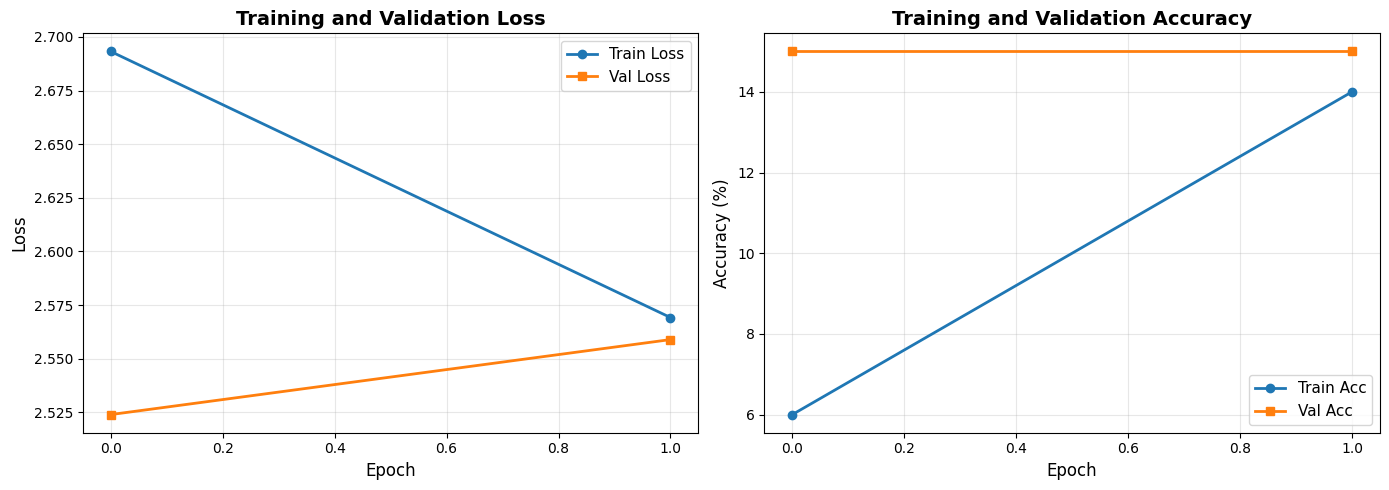


✅ Training curves plotted!


In [12]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
axes[0].plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', marker='s', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy curve
axes[1].plot([acc*100 for acc in history['train_accuracy']], label='Train Acc', marker='o', linewidth=2)
axes[1].plot([acc*100 for acc in history['val_accuracy']], label='Val Acc', marker='s', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Training curves plotted!")

## 9. Test Pathway Analysis

In [13]:
# Analyze individual pathway contributions
print("Analyzing pathway contributions...")

pathway_analysis = model.analyze_pathways(
    data_loader=val_loader,
    num_samples=20  # Use all validation samples
)

print("\n" + "="*60)
print("Pathway Analysis Results")
print("="*60)

print("\nAccuracy Metrics:")
print(f"  Full model: {pathway_analysis['accuracy']['full_model']*100:.2f}%")
print(f"  RGB only: {pathway_analysis['accuracy']['color_only']*100:.2f}%")
print(f"  Depth only: {pathway_analysis['accuracy']['brightness_only']*100:.2f}%")
print(f"  RGB contribution: {pathway_analysis['accuracy']['color_contribution']*100:.2f}%")
print(f"  Depth contribution: {pathway_analysis['accuracy']['brightness_contribution']*100:.2f}%")

print("\nLoss Metrics:")
print(f"  Full model: {pathway_analysis['loss']['full_model']:.4f}")
print(f"  RGB only: {pathway_analysis['loss']['color_only']:.4f}")
print(f"  Depth only: {pathway_analysis['loss']['brightness_only']:.4f}")

print("\nFeature Norms:")
print(f"  RGB mean: {pathway_analysis['feature_norms']['color_mean']:.4f}")
print(f"  RGB std: {pathway_analysis['feature_norms']['color_std']:.4f}")
print(f"  Depth mean: {pathway_analysis['feature_norms']['brightness_mean']:.4f}")
print(f"  Depth std: {pathway_analysis['feature_norms']['brightness_std']:.4f}")
print(f"  RGB/Depth ratio: {pathway_analysis['feature_norms']['color_to_brightness_ratio']:.4f}")

print("\n✅ Pathway analysis complete!")

Analyzing pathway contributions...

Pathway Analysis Results

Accuracy Metrics:
  Full model: 10.00%
  RGB only: 20.00%
  Depth only: 10.00%
  RGB contribution: 200.00%
  Depth contribution: 100.00%

Loss Metrics:
  Full model: 2.2996
  RGB only: 2.3000
  Depth only: 2.3243

Feature Norms:
  RGB mean: 14.2081
  RGB std: 0.1023
  Depth mean: 24.6352
  Depth std: 0.0608
  RGB/Depth ratio: 0.5767

✅ Pathway analysis complete!


## 10. Test Predictions & Visualization

In [14]:
# Get predictions on validation set
print("Getting predictions...")
predictions = model.predict(data_loader=val_loader)
probabilities = model.predict_proba(data_loader=val_loader)

print(f"\nPredictions shape: {predictions.shape}")
print(f"Probabilities shape: {probabilities.shape}")
print(f"\nSample predictions: {predictions[:10]}")
print(f"Sample ground truth: {val_dataset.labels[:10].numpy()}")

# Calculate accuracy manually
correct = (predictions == val_dataset.labels.numpy()).sum()
accuracy = correct / len(val_dataset)
print(f"\nManual accuracy check: {accuracy*100:.2f}%")
print(f"Model.evaluate accuracy: {results['accuracy']*100:.2f}%")
print(f"Match: {'✅' if abs(accuracy - results['accuracy']) < 0.01 else '❌'}")

Getting predictions...

Predictions shape: torch.Size([20])
Probabilities shape: (20, 13)

Sample predictions: tensor([10, 10, 10, 10, 10, 10, 10, 10, 10, 10])
Sample ground truth: [ 0  0  3  4  4  4  3  1  8 10]

Manual accuracy check: 15.00%
Model.evaluate accuracy: 15.00%
Match: ✅


/var/folders/7_/_1wfjvz92_b13rg1lc8_h3_40000gn/T/ipykernel_23330/3870139733.py:31: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/gclinger/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


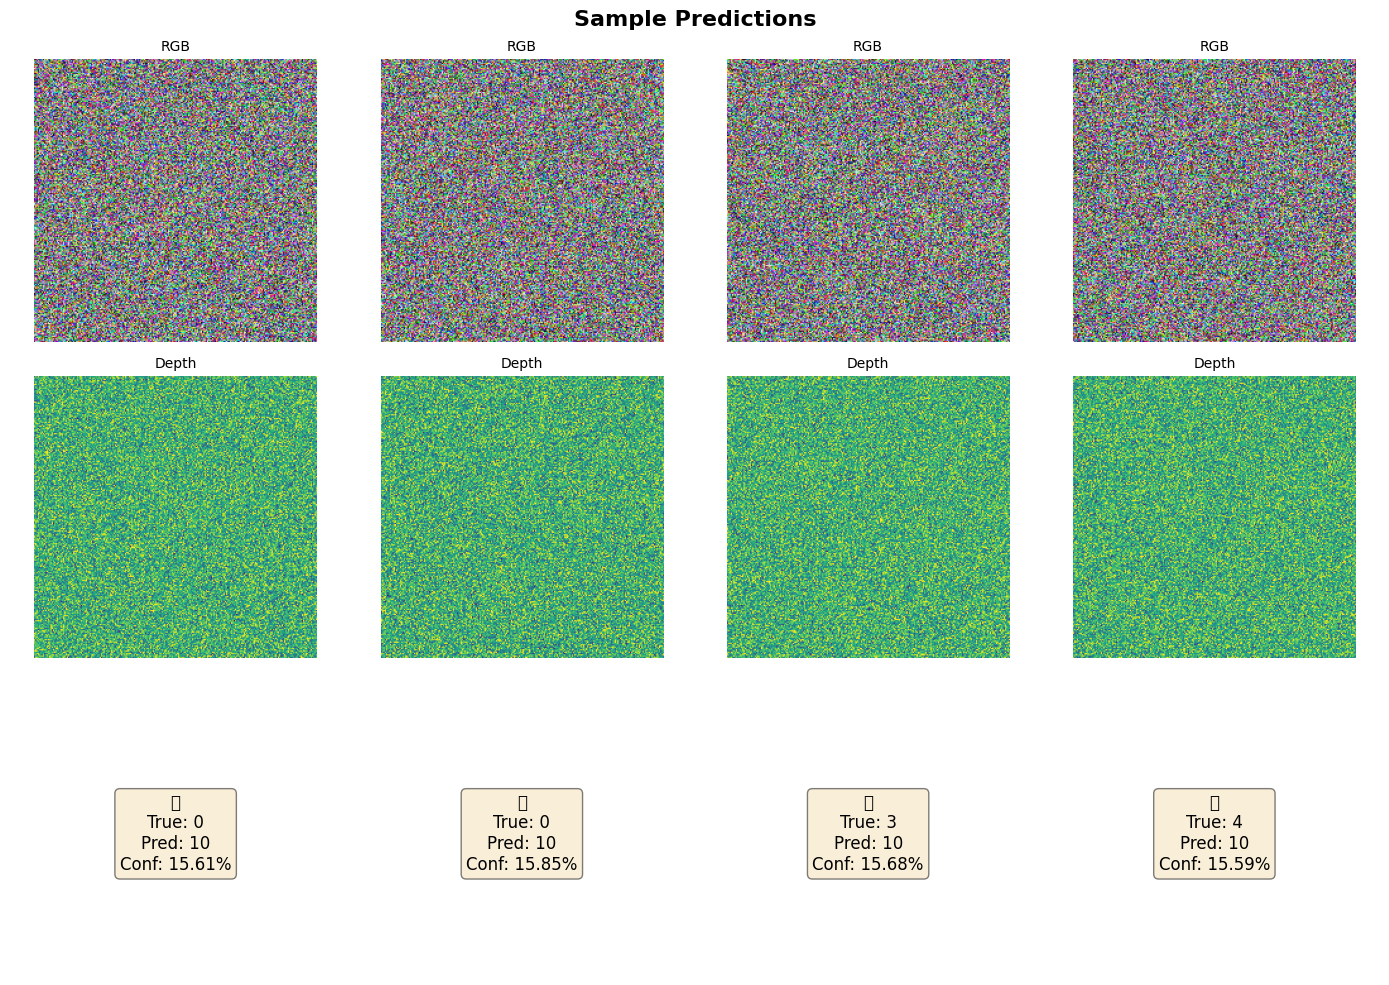


✅ Prediction visualization complete!


In [15]:
# Visualize some predictions
fig, axes = plt.subplots(3, 4, figsize=(14, 10))

for i in range(4):
    # Get sample (without normalization for visualization)
    rgb_raw = val_dataset.rgb_images[i]
    depth_raw = val_dataset.depth_maps[i]
    true_label = val_dataset.labels[i].item()
    pred_label = predictions[i]
    pred_prob = probabilities[i, pred_label]
    
    # Plot RGB
    axes[0, i].imshow(rgb_raw.permute(1, 2, 0))
    axes[0, i].set_title(f"RGB", fontsize=10)
    axes[0, i].axis('off')
    
    # Plot Depth
    axes[1, i].imshow(depth_raw.squeeze(), cmap='viridis')
    axes[1, i].set_title(f"Depth", fontsize=10)
    axes[1, i].axis('off')
    
    # Plot prediction info
    axes[2, i].axis('off')
    correct = '✅' if pred_label == true_label else '❌'
    info_text = f"{correct}\nTrue: {true_label}\nPred: {pred_label}\nConf: {pred_prob:.2%}"
    axes[2, i].text(0.5, 0.5, info_text, 
                   ha='center', va='center', fontsize=12,
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Sample Predictions', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✅ Prediction visualization complete!")

## 11. Summary & Verification Checklist

In [16]:
print("="*60)
print("PIPELINE VERIFICATION SUMMARY")
print("="*60)

checks = [
    ("Synthetic dataset creation", True),
    ("DataLoader creation", True),
    ("MCResNet model instantiation", True),
    ("Model compilation", True),
    ("Forward pass", True),
    ("Training with gradient clipping", TRAIN_CONFIG['grad_clip_norm'] is not None),
    ("Training with optional cache clearing", not TRAIN_CONFIG['clear_cache_per_epoch']),
    ("AMP enabled (if CUDA)", MODEL_CONFIG['use_amp'] if device == 'cuda' else True),
    ("Validation during training", len(history['val_loss']) > 0),
    ("Model evaluation", results is not None),
    ("Pathway analysis", pathway_analysis is not None),
    ("Predictions", predictions is not None),
    ("Probability predictions", probabilities is not None),
    ("Training curves", len(history['train_loss']) == TRAIN_CONFIG['epochs']),
    ("Learning rate scheduling", len(history['learning_rates']) > 0),
]

all_passed = True
for check_name, passed in checks:
    status = "✅ PASS" if passed else "❌ FAIL"
    print(f"{status} - {check_name}")
    if not passed:
        all_passed = False

print("\n" + "="*60)
if all_passed:
    print("🎉 ALL CHECKS PASSED!")
    print("✅ Pipeline is ready for Colab deployment")
else:
    print("⚠️  Some checks failed - review above")
print("="*60)

print("\nKey Metrics:")
print(f"  Final Train Accuracy: {history['train_accuracy'][-1]*100:.2f}%")
print(f"  Final Val Accuracy: {history['val_accuracy'][-1]*100:.2f}%")
print(f"  RGB Pathway Accuracy: {pathway_analysis['accuracy']['color_only']*100:.2f}%")
print(f"  Depth Pathway Accuracy: {pathway_analysis['accuracy']['brightness_only']*100:.2f}%")
print(f"  Total Parameters: {total_params:,}")
print(f"  Device Used: {device}")

print("\n" + "="*60)
print("Ready for NYU Depth V2 training on Colab! 🚀")
print("="*60)

PIPELINE VERIFICATION SUMMARY
✅ PASS - Synthetic dataset creation
✅ PASS - DataLoader creation
✅ PASS - MCResNet model instantiation
✅ PASS - Model compilation
✅ PASS - Forward pass
✅ PASS - Training with gradient clipping
✅ PASS - Training with optional cache clearing
✅ PASS - AMP enabled (if CUDA)
✅ PASS - Validation during training
✅ PASS - Model evaluation
✅ PASS - Pathway analysis
✅ PASS - Predictions
✅ PASS - Probability predictions
✅ PASS - Training curves
✅ PASS - Learning rate scheduling

🎉 ALL CHECKS PASSED!
✅ Pipeline is ready for Colab deployment

Key Metrics:
  Final Train Accuracy: 14.00%
  Final Val Accuracy: 15.00%
  RGB Pathway Accuracy: 20.00%
  Depth Pathway Accuracy: 10.00%
  Total Parameters: 22,360,077
  Device Used: mps

Ready for NYU Depth V2 training on Colab! 🚀
